In [1]:
import time
import pymongo
from pymongo import MongoClient

start = time.time()

#--------------------FUNCTIONS FOR LARGE PROTEIN FASTA ASSEMBLY USING MONGODB--------------------

#Extract proteinIDs from DTASelect Proteins for mongoDB protein fasta assembly
#input: DTAselect Protein file
#output: proteinID list
def extractProteinID(DTA_select_file):
    proteinlist1 = []
    with open(DTA_select_file, 'r') as h:
        file1 = h.readlines()
    for line1 in file1:
        line2 = line1.split('\t')
        if (line2[0] == "Unique"):
            index1 = file1.index(line1)
            break
    for line1 in range((index1+1), len(file1)):
        line2 = file1[line1].split('\t')
        if (line2[0] != "") and (line2[0] != '*') and (line2[1] != "Proteins"):
            proteinlist1.append(line2[0])
        elif (line2[1] == "Proteins"):
            break
    return proteinlist1

#search mongodatabase for protein sequences
#input: proteinID list and name of output fasta file
#output: fasta file containing proteinIDs and protein sequences
def findProtSeq(plist1, output_file):
    client = MongoClient("localhost", 27017)
    db = client['ProtDB_compil1501']
    outputfile1 = open(output_file, 'w')
    for item1 in plist1:
        protein1 = db.ProtDB_compil1501.find_one({ "b" : item1 })
        outputfile1.write(">" + protein1['d'] + "\n")
        outputfile1.write(protein1['s'] + "\n")
    outputfile1.close()

#-----------------FUNCTIONS FOR ASSEMBLING CLUSTER-SPECTRAL COUNT TABLE FOR DESEQ2-----------------

#create list of unique vs non-unique peptides; 
#input is DTASelect Peptide file
#output is printed result, no return
def determineUniqueness(file_to_open):
    unique = []
    nonunique = []
    with open(file_to_open, 'r') as f:
        file1 = f.readlines()  
    for line1 in range(1, len(file1)):
        line2 = file1[line1].split('\t')
        if '*' in line2[13]:
            unique.append(line2[12])
        else:
            nonunique.append(line2[12]) 
    print("Unique peptides:", len(set(unique)))
    print("Non-unique peptides:", len(set(nonunique)))

#create count of all CD-HIT clusterIDs
#input is CD-HIT cluster file
#output is integer count of clusters
def createClusterIndex(cluster_file):
    with open(cluster_file, 'r') as g:
        file1 = g.readlines()
    clustercount = 0
    for line1 in file1:
        if line1[0] == ">":
            clustercount += 1
    return clustercount

#create dictionary linking proteinIDs (keys) to CD-HIT clusterIDs (values)
#input is CD-HIT cluster file
#output is ProteinID-cdhitID dictionary
def createProteinClusterDict(cluster_file):
    with open(cluster_file, 'r') as g:
        file1 = g.readlines()
    clusterID = ""
    proteindict1 = {}
    for line1 in file1:
        line2 = line1.split()
        if ">" in line2[0][0]:
            clusterID = line2[1]
        else:
            proteindict1[line2[2][1:-3]] = clusterID
    return proteindict1

#create file linking proteinIDs to peptides in DTAselect file 
#first input is DTASelect Protein file
#first output is file (dump.txt) where clusterIDs(non-indented) associate with peptides (indented)
#create dictionary linking peptides (keys; str) and clusterIDs (values); clusterIDs = list of non-redundant integers
#second input is protein-clusterID dictionary
#second output is peptide-ClusterID dictionary
def createPeptideClusterIDDict(DTA_select_file, proteindict1):
    #----------PART 1----------
    with open(DTA_select_file, 'r') as h:
        file1 = h.readlines()
    for line1 in file1:
        line2 = line1.split('\t')
        if (line2[0] == "Unique"):
            index1 = file1.index(line1)
            break
    outputfile1 = open("dump.txt", 'w')
    for line1 in range((index1+1), len(file1)):
        line2 = file1[line1].split('\t')
        if (line2[0] != "") and (line2[0] != '*') and (line2[1] != "Proteins"):
            #Note this Try/Except line was added to take care of contaminant proteins in non-microbiome searches
            try:
                outputfile1.write(proteindict1[line2[0]] + "\n")
            except:
                pass
        elif ((line2[0] == "") or (line2[0] == '*')) and (line2[1] != "Proteins"):
            #Note splice at line2[14] added to take care of non-microbiome searches
            outputfile1.write("\t" + line2[14][1:-1] + "\n")
        else:
            break
    outputfile1.close()
    #----------PART 2----------
    with open("dump.txt", 'r') as i:
        file2 = i.readlines()
    clusterlist1 = []
    peptidedict1 = {}
    newcluster = False
    for line1 in file2:
        line2 = line1.split('\t')
        if (line2[0] != ''):
            if newcluster == True:
                clusterlist1 = []
                newcluster = False
            clusterlist1.append(int(line2[0].replace('\n', '')))
        elif (line2[0] == ''):
            peptidedict1[line2[1].replace('\n', '')] = clusterlist1
            newcluster = True
        else:
            break
    for key1 in peptidedict1.keys():
        peptidedict1[key1] = list(set(peptidedict1[key1]))
    return peptidedict1

#create dictionary linking peptides (keys; str) to spec counts (values; int)
#input is DTASelect Peptide file
#output is peptide-SC dictionary
def createPeptideSCDict(file_to_open):
    with open(file_to_open, 'r') as j:
        file1 = j.readlines()
    speccountdict1 = {}
    for line1 in range(1, len(file1)):
        line2 = file1[line1].split('\t')
        if line2[12] in speccountdict1:
            speccountdict1[line2[12][1:-1].replace('\n', '')] += int(line2[11])
        else:
            speccountdict1[line2[12][1:-1].replace('\n', '')] = int(line2[11])
    return speccountdict1

#create dictionary linking clusterIDs (keys; int) to spec counts (values; int)
#peptides mapping to >1 cluster are not counted, empty clusters are not filled in with 0
#input is peptide-SC dictionary and peptide-ClusterID dictionary
#output is clusterID-SC dictionary
def createClusterIDSCDict(SCdict1, clustdict1):
    clusterspeccountdict1 = {}
    tempclusternumber1 = 0
    multiclustercount = 0
    singleclustercount = 0
    for key1 in clustdict1.keys():
        if len(clustdict1[key1]) == 1:
            if clustdict1[key1][0] in clusterspeccountdict1:
                clusterspeccountdict1[clustdict1[key1][0]] += SCdict1[key1]
            else:
                clusterspeccountdict1[clustdict1[key1][0]] = SCdict1[key1]
            singleclustercount += 1
        else:
            #for item1 in clustdict1[key1]:
            #    clusterspeccountdict1[item1] = 0
            multiclustercount += 1
    print("Single Cluster Assignments:", singleclustercount)
    print("Multi Cluster Assignments:", multiclustercount)
    return clusterspeccountdict1

#input: cluster-spectral count dictionary, total number of clusters
#output: cluster-spectral count dictionary with all cluster keys present
def missingValues(clusterSCDict, clustercount):
    for item1 in range(0, clustercount):
        if item1 not in clusterSCDict.keys():
            clusterSCDict[item1] = 0
    return clusterSCDict

#processes all lower functions for single Compil2 Search
#input is cdhit cluster file, DTAselect protein file, and DTAselect peptide file
#output is cluster-spectral count dictionary with 0 values filled in; cluster# (keys; int) vs SC (values; int)
def processAll(cdhit_file, DTAselect_protein_file, DTAselect_peptide_file):
    var1 = createProteinClusterDict(cdhit_file)
    var2 = createPeptideClusterIDDict(DTAselect_protein_file, var1)
    var3 = createPeptideSCDict(DTAselect_peptide_file)
    var4 = createClusterIDSCDict(var3, var2)
    var5 = createClusterIndex(cdhit_file)
    var6 = missingValues(var4, var5)
    return var6

end = time.time()
print(end-start)

0.0013561248779296875


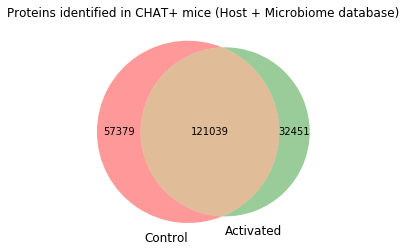

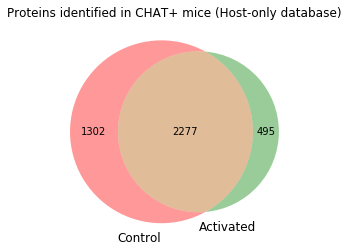

3.5735909938812256


In [11]:
start = time.time()

#-----------Extract ProteinIDs-----------

list1 = extractProteinID("MB-DTASelect/1-MB.txt")
list2 = extractProteinID("MB-DTASelect/2-MB.txt")
list3 = extractProteinID("MB-DTASelect/3-MB.txt")
list4 = extractProteinID("MB-DTASelect/4-MB.txt")
list5 = extractProteinID("MB-DTASelect/5-MB.txt")
list6 = extractProteinID("MB-DTASelect/6-MB.txt")
list7 = extractProteinID("MB-DTASelect/7-MB.txt")
list8 = extractProteinID("MB-DTASelect/8-MB.txt")
list9 = extractProteinID("MB-DTASelect/9-MB.txt")
list10 = extractProteinID("MB-DTASelect/10-MB.txt")
list11 = extractProteinID("MB-DTASelect/11-MB.txt")
list12 = extractProteinID("MB-DTASelect/12-MB.txt")
list13 = extractProteinID("MB-DTASelect/13-MB.txt")
list14 = extractProteinID("MB-DTASelect/14-MB.txt")
list15 = extractProteinID("MB-DTASelect/15-MB.txt")
list16 = extractProteinID("MB-DTASelect/16-MB.txt")
list17 = extractProteinID("MB-DTASelect/17-MB.txt")

mlist1 = extractProteinID("mouse-DTASelect/1-mouse.txt")
mlist2 = extractProteinID("mouse-DTASelect/2-mouse.txt")
mlist3 = extractProteinID("mouse-DTASelect/3-mouse.txt")
mlist4 = extractProteinID("mouse-DTASelect/4-mouse.txt")
mlist5 = extractProteinID("mouse-DTASelect/5-mouse.txt")
mlist6 = extractProteinID("mouse-DTASelect/6-mouse.txt")
mlist7 = extractProteinID("mouse-DTASelect/7-mouse.txt")
mlist8 = extractProteinID("mouse-DTASelect/8-mouse.txt")
mlist9 = extractProteinID("mouse-DTASelect/9-mouse.txt")
mlist10 = extractProteinID("mouse-DTASelect/10-mouse.txt")
mlist11 = extractProteinID("mouse-DTASelect/11-mouse.txt")
mlist12 = extractProteinID("mouse-DTASelect/12-mouse.txt")
mlist13 = extractProteinID("mouse-DTASelect/13-mouse.txt")
mlist14 = extractProteinID("mouse-DTASelect/14-mouse.txt")
mlist15 = extractProteinID("mouse-DTASelect/15-mouse.txt")
mlist16 = extractProteinID("mouse-DTASelect/16-mouse.txt")
mlist17 = extractProteinID("mouse-DTASelect/17-mouse.txt")

#------Create Master ProteinID list------

masterset1 = set(list1).union(set(list2)).union(set(list3)).union(set(list4)).union(set(list5)).union(set(list6)).union(set(list7)).union(set(list8)).union(set(list9)).union(set(list10)).union(set(list11)).union(set(list12)).union(set(list13)).union(set(list14)).union(set(list15)).union(set(list16)).union(set(list17))
masterlist1 = list(masterset1)


#-------------Venn Diagrams--------------

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

MBcontrol_only = set(list1).union(set(list2)).union(set(list3)).union(set(list4)).union(set(list5)).union(set(list6)).union(set(list7)).union(set(list8)).union(set(list9))
MBactivated_only = set(list10).union(set(list11)).union(set(list12)).union(set(list13)).union(set(list14)).union(set(list15)).union(set(list16)).union(set(list17))

mousecontrol_only = set(mlist1).union(set(mlist2)).union(set(mlist3)).union(set(mlist4)).union(set(mlist5)).union(set(mlist6)).union(set(mlist7)).union(set(mlist8)).union(set(mlist9))
mouseactivated_only = set(mlist10).union(set(mlist11)).union(set(mlist12)).union(set(mlist13)).union(set(mlist14)).union(set(mlist15)).union(set(mlist16)).union(set(mlist17))

venn2([MBcontrol_only, MBactivated_only], set_labels = ('Control', 'Activated'))
plt.title('Proteins identified in CHAT+ mice (Host + Microbiome database)')
plt.savefig('CHAT_MB_venn.svg')
plt.show()

venn2([mousecontrol_only, mouseactivated_only], set_labels = ('Control', 'Activated'))
plt.title('Proteins identified in CHAT+ mice (Host-only database)')
plt.savefig('CHAT_mouse_venn.svg')
plt.show()

#-----------Write lists out--------------

MBcontrol_only = list(MBcontrol_only)
MBactivated_only = list(MBactivated_only)

with open('CHAT_MB_control_only.txt', 'w') as f:
    for item in MBcontrol_only:
        f.write(item)
        f.write('\n')
        
with open('CHAT_MB_activated_only.txt', 'w') as g:
    for item in MBactivated_only:
        g.write(item)
        g.write('\n')
        

MBcontrol_only = list(MBcontrol_only)
MBactivated_only = list(MBactivated_only)

with open('CHAT_mouse_control_only.txt', 'w') as h:
    for item in mousecontrol_only:
        h.write(item)
        h.write('\n')
        
with open('CHAT_mouse_activated_only.txt', 'w') as i:
    for item in mouseactivated_only:
        i.write(item)
        i.write('\n')

#------Create Master Protein Fasta-------

#findProtSeq(masterlist1, "chat-fastadump1.fasta")

end = time.time()
print(end-start)

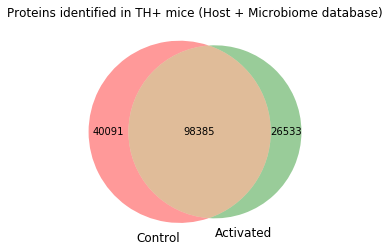

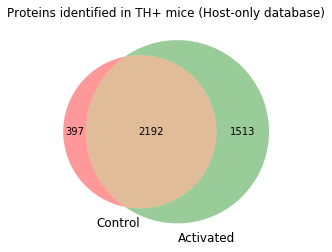

2.4222571849823


In [12]:
start = time.time()

#-----------Extract ProteinIDs-----------

list18 = extractProteinID("MB-DTASelect/18-MB.txt")
list19 = extractProteinID("MB-DTASelect/19-MB.txt")
list20 = extractProteinID("MB-DTASelect/20-MB.txt")
list21 = extractProteinID("MB-DTASelect/21-MB.txt")
list22 = extractProteinID("MB-DTASelect/22-MB.txt")
list23 = extractProteinID("MB-DTASelect/23-MB.txt")
list24 = extractProteinID("MB-DTASelect/24-MB.txt")
list25 = extractProteinID("MB-DTASelect/25-MB.txt")
list26 = extractProteinID("MB-DTASelect/26-MB.txt")
list27 = extractProteinID("MB-DTASelect/27-MB.txt")
list28 = extractProteinID("MB-DTASelect/28-MB.txt")
list29 = extractProteinID("MB-DTASelect/29-MB.txt")
list30 = extractProteinID("MB-DTASelect/30-MB.txt")
list31 = extractProteinID("MB-DTASelect/31-MB.txt")

mlist18 = extractProteinID("mouse-DTASelect/18-mouse.txt")
mlist19 = extractProteinID("mouse-DTASelect/19-mouse.txt")
mlist20 = extractProteinID("mouse-DTASelect/20-mouse.txt")
mlist21 = extractProteinID("mouse-DTASelect/21-mouse.txt")
mlist22 = extractProteinID("mouse-DTASelect/22-mouse.txt")
mlist23 = extractProteinID("mouse-DTASelect/23-mouse.txt")
mlist24 = extractProteinID("mouse-DTASelect/24-mouse.txt")
mlist25 = extractProteinID("mouse-DTASelect/25-mouse.txt")
mlist26 = extractProteinID("mouse-DTASelect/26-mouse.txt")
mlist27 = extractProteinID("mouse-DTASelect/27-mouse.txt")
mlist28 = extractProteinID("mouse-DTASelect/28-mouse.txt")
mlist29 = extractProteinID("mouse-DTASelect/29-mouse.txt")
mlist30 = extractProteinID("mouse-DTASelect/30-mouse.txt")
mlist31 = extractProteinID("mouse-DTASelect/31-mouse.txt")


#-------------Venn Diagrams--------------

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

MBcontrol_only = set(list18).union(set(list19)).union(set(list20)).union(set(list21)).union(set(list22)).union(set(list23)).union(set(list24))
MBactivated_only = set(list25).union(set(list26)).union(set(list27)).union(set(list28)).union(set(list29)).union(set(list30)).union(set(list31))

mousecontrol_only = set(mlist18).union(set(mlist19)).union(set(mlist20)).union(set(mlist21)).union(set(mlist22)).union(set(mlist23)).union(set(mlist24))
mouseactivated_only = set(mlist25).union(set(mlist26)).union(set(mlist27)).union(set(mlist28)).union(set(mlist29)).union(set(mlist30)).union(set(mlist31))

venn2([MBcontrol_only, MBactivated_only], set_labels = ('Control', 'Activated'))
plt.title('Proteins identified in TH+ mice (Host + Microbiome database)')
plt.savefig('TH_MB_venn.svg')
plt.show()

venn2([mousecontrol_only, mouseactivated_only], set_labels = ('Control', 'Activated'))
plt.title('Proteins identified in TH+ mice (Host-only database)')
plt.savefig('TH_mouse_venn.svg')
plt.show()

#-----------Write lists out--------------

MBcontrol_only = list(MBcontrol_only)
MBactivated_only = list(MBactivated_only)

with open('TH_MB_control_only.txt', 'w') as f:
    for item in MBcontrol_only:
        f.write(item)
        f.write('\n')
        
with open('TH_MB_activated_only.txt', 'w') as g:
    for item in MBactivated_only:
        g.write(item)
        g.write('\n')
        

MBcontrol_only = list(MBcontrol_only)
MBactivated_only = list(MBactivated_only)

with open('TH_mouse_control_only.txt', 'w') as h:
    for item in mousecontrol_only:
        h.write(item)
        h.write('\n')
        
with open('TH_mouse_activated_only.txt', 'w') as i:
    for item in mouseactivated_only:
        i.write(item)
        i.write('\n')


end = time.time()
print(end-start)